<a href="https://colab.research.google.com/github/bokuwakira1411/Data-mining---ex2-3/blob/main/exercise_2%2B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Xử lý dữ liệu training set

In [ ]:

df_train = pd.read_csv("/content/labeled_train.csv")
df_train.head()

,Date,Time,Open,High,Low,Close,Volume,Label
0,2011-01-03,01:00,1415.71,1416.54,1415.10,1415.63,1035,SELL
1,2011-01-03,02:00,1415.64,1416.43,1414.90,1415.98,736,SELL
2,2011-01-03,03:00,1415.95,1417.89,1414.59,1416.54,922,SELL
3,2011-01-03,04:00,1416.51,1418.64,1415.25,1416.75,1060,SELL
4,2011-01-03,05:00,1416.76,1420.00,1416.76,1419.48,838,SELL


In [ ]:
df_train.isnull().sum()

,0
Date,0
Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [ ]:
df_train['Date Time'] = pd.to_datetime(df_train['Date'] + ' ' + df_train['Time'])
df_train = df_train.set_index('Date Time').drop(columns=['Date', 'Time'])
df_train.head()

,Open,High,Low,Close,Volume,Label
Date Time,,,,,,
2011-01-03 01:00:00,1415.71,1416.54,1415.10,1415.63,1035,SELL
2011-01-03 02:00:00,1415.64,1416.43,1414.90,1415.98,736,SELL
2011-01-03 03:00:00,1415.95,1417.89,1414.59,1416.54,922,SELL
2011-01-03 04:00:00,1416.51,1418.64,1415.25,1416.75,1060,SELL
2011-01-03 05:00:00,1416.76,1420.00,1416.76,1419.48,838,SELL


# Line plot

In [ ]:
df_train.dtypes

,0
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64
Label,object


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

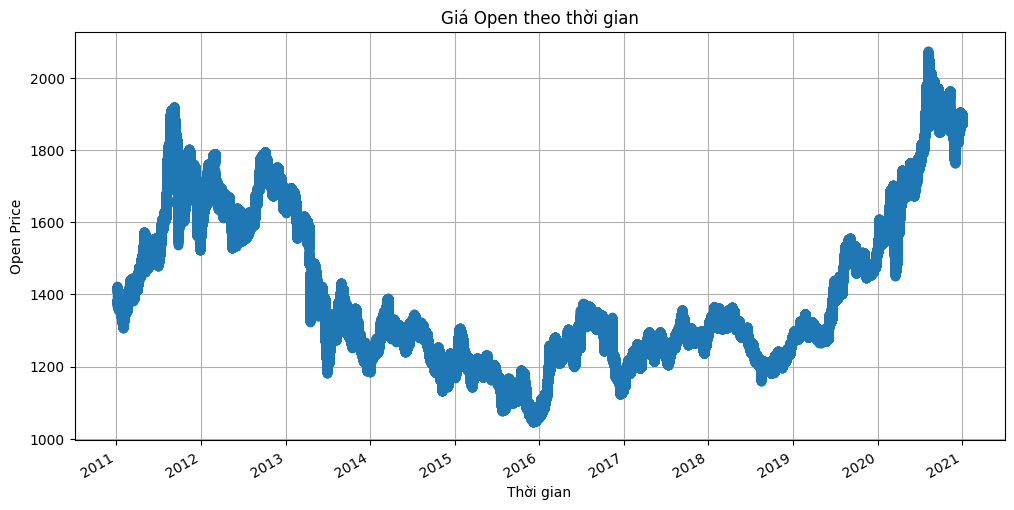

In [ ]:
df_train['Open'].plot(title='Giá Open theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('Open Price')
plt.grid(True)
plt.show()


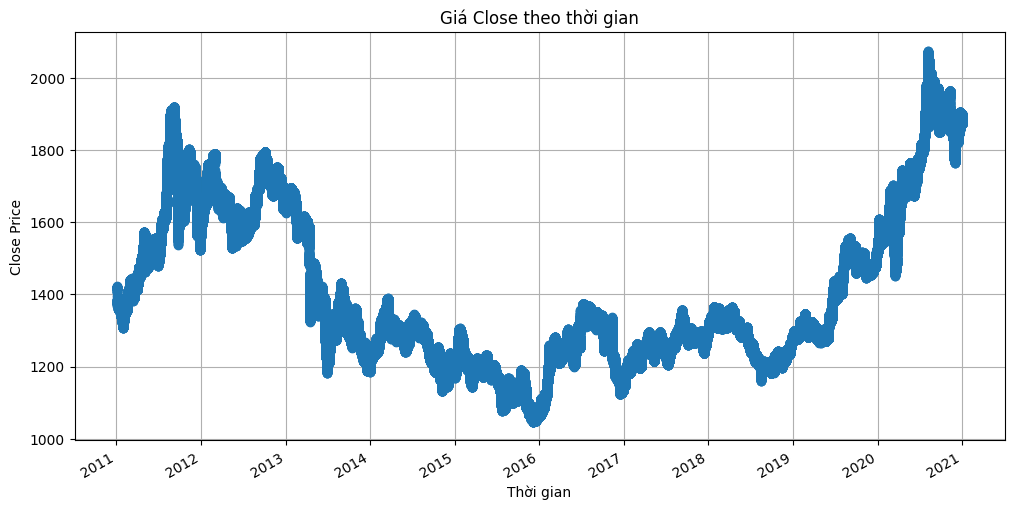

In [ ]:
df_train['Close'].plot(title='Giá Close theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


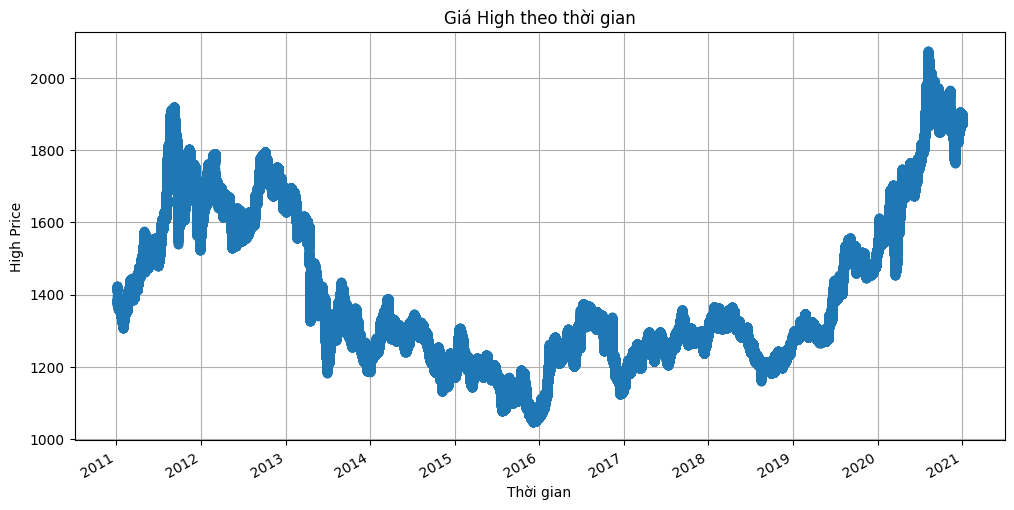

In [ ]:
df_train['High'].plot(title='Giá High theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('High Price')
plt.grid(True)
plt.show()


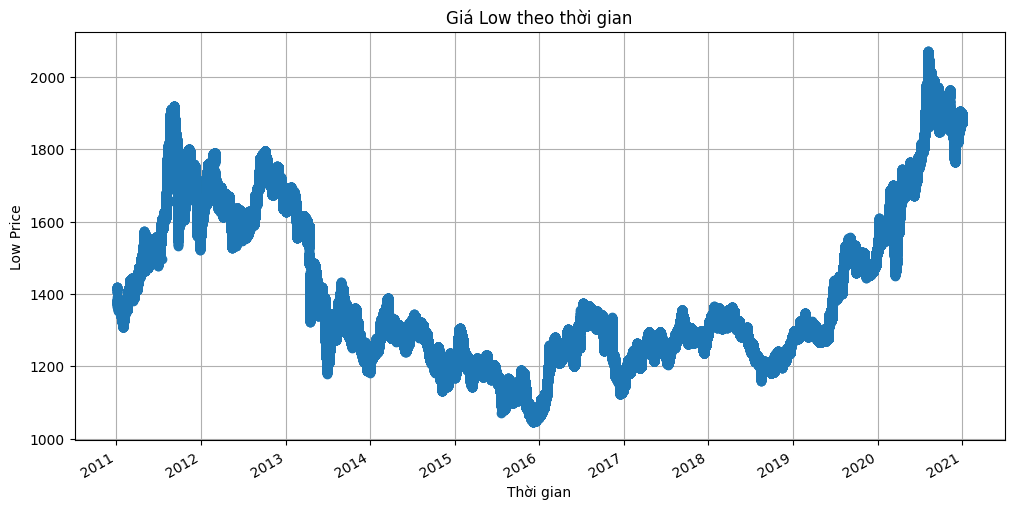

In [ ]:
df_train['Low'].plot(title='Giá Low theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('Low Price')
plt.grid(True)
plt.show()


### Sample dữ liệu bị thiếu

In [ ]:
# Xử lý thiếu dữ liệu bằng phương pháp forward fill cho 10 phút ngay sau, nếu vẫn cần sample tiếp thì sử dụng interpolate time.

df_train['source'] = 'original'     # Thêm cột đánh dấu là dữ liệu sample hay original
df_train_resampled = df_train.resample('1T').ffill(limit=10)
df_train_resampled = df_train_resampled.interpolate(method='time')

# # Đánh dấu các dòng nào là original (có trong index gốc)
df_train_resampled['source'] = df_train_resampled.index.isin(df_train.index)
df_train_resampled['source'] = df_train_resampled['source'].map({True: 'original', False: 'sampled'})

df_train_resampled.iloc[55:65]

<ipython-input-6-a662acf6b23f>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_train_resampled = df_train.resample('1T').ffill(limit=10)
<ipython-input-6-a662acf6b23f>:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_train_resampled = df_train_resampled.interpolate(method='time')


,Open,High,Low,Close,Volume,Label,source
Date Time,,,,,,,
2011-01-03 01:55:00,1415.6470,1416.4410,1414.920,1415.945,765.90,NaN,sampled
2011-01-03 01:56:00,1415.6456,1416.4388,1414.916,1415.952,759.92,NaN,sampled
2011-01-03 01:57:00,1415.6442,1416.4366,1414.912,1415.959,753.94,NaN,sampled
2011-01-03 01:58:00,1415.6428,1416.4344,1414.908,1415.966,747.96,NaN,sampled
2011-01-03 01:59:00,1415.6414,1416.4322,1414.904,1415.973,741.98,NaN,sampled
2011-01-03 02:00:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,original
2011-01-03 02:01:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,sampled
2011-01-03 02:02:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,sampled
2011-01-03 02:03:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,sampled


In [ ]:
print(df_train.shape)
print(df_train_resampled.shape)

(3446549, 7)
(5257098, 7)


### Tính toán để gán Label cho dữ liệu vừa sample được

In [ ]:
# Gán label cho dữ liệu đã sample (chỉ dữ liệu sử dụng interpolate time,
# vì dữ liệu sample 10 phút ban đầu bằng bfill chỉ điền giống dữ liệu gần nhất nên không cần gán lại Label)

delta_minutes = 30
threshold = 0.000505
df_train_resampled['price_future'] = df_train_resampled['Close'].shift(-delta_minutes)

mask_no_label = df_train_resampled['Label'].isna()

df_train_resampled.loc[mask_no_label, 'Label'] = np.select(
    [
        df_train_resampled.loc[mask_no_label, 'price_future'] > df_train_resampled.loc[mask_no_label, 'Close'] * (1 + threshold),
        df_train_resampled.loc[mask_no_label, 'price_future'] < df_train_resampled.loc[mask_no_label, 'Close'] * (1 - threshold)
    ],
    ['BUY', 'SELL'],
    default='HOLD'
)
df_train_resampled.drop(columns='price_future', inplace= True)
df_train_resampled.iloc[55:65]

,Open,High,Low,Close,Volume,Label,source
Date Time,,,,,,,
2011-01-03 01:55:00,1415.6470,1416.4410,1414.920,1415.945,765.90,HOLD,sampled
2011-01-03 01:56:00,1415.6456,1416.4388,1414.916,1415.952,759.92,HOLD,sampled
2011-01-03 01:57:00,1415.6442,1416.4366,1414.912,1415.959,753.94,HOLD,sampled
2011-01-03 01:58:00,1415.6428,1416.4344,1414.908,1415.966,747.96,HOLD,sampled
2011-01-03 01:59:00,1415.6414,1416.4322,1414.904,1415.973,741.98,HOLD,sampled
2011-01-03 02:00:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,original
2011-01-03 02:01:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,sampled
2011-01-03 02:02:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,sampled
2011-01-03 02:03:00,1415.6400,1416.4300,1414.900,1415.980,736.00,SELL,sampled


### Tính toán các cột dữ liệu thành % thay đổi so với thời điểm ngay trước

In [ ]:
change_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Tính phần trăm thay đổi (returns) cho từng cột
for col in change_cols:
    df_train_resampled[f'{col}_return'] = df_train_resampled[col].pct_change()

# Loại bỏ dòng đầu tiên (vì không có dữ liệu để tính % thay đổi)
df_train_resampled = df_train_resampled.dropna(subset=[f'{col}_return' for col in change_cols])

df_train_resampled.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

df_train_resampled.tail()

,Label,source,Open_return,High_return,Low_return,Close_return,Volume_return
Date Time,,,,,,,
2020-12-31 19:13:00,BUY,original,-0.000169,0.000360,-0.000111,0.000529,0.417722
2020-12-31 19:14:00,BUY,original,0.000529,0.000333,0.000672,0.000143,-0.312500
2020-12-31 19:15:00,BUY,original,0.000095,-0.000227,-0.000058,-0.000137,-0.116883
2020-12-31 19:16:00,BUY,original,-0.000090,-0.000079,-0.000248,-0.000312,0.102941
2020-12-31 19:17:00,BUY,original,-0.000312,-0.000270,-0.000143,0.000005,-0.040000


### Chuẩn hoá dữ liệu Z-score, đưa dữ liệu về phân phối có trung bình = 0 và độ lệch chuẩn = 1

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['Open_return', 'High_return', 'Low_return', 'Close_return',	'Volume_return']
scaler = StandardScaler()

# Fit và transform
df_train_resampled[feature_cols] = scaler.fit_transform(df_train_resampled[feature_cols])
df_train_resampled.tail()

,Label,source,Open_return,High_return,Low_return,Close_return,Volume_return
Date Time,,,,,,,
2020-12-31 19:13:00,BUY,original,-0.774661,1.822141,-0.529054,2.422634,0.181306
2020-12-31 19:14:00,BUY,original,2.419735,1.687525,3.197280,0.653501,-0.323131
2020-12-31 19:15:00,BUY,original,0.435026,-1.152055,-0.277143,-0.629918,-0.187999
2020-12-31 19:16:00,BUY,original,-0.411521,-0.402217,-1.183024,-1.429166,-0.036144
2020-12-31 19:17:00,BUY,original,-1.427456,-1.366739,-0.679935,0.023863,-0.134888


## Xử lý dữ liệu development set

In [ ]:
df_dev = pd.read_csv("/content/labeled_dev.csv")
df_dev.head()

,Date,Time,Open,High,Low,Close,Volume,Label
0,2021-01-04,00:05,1909.07,1909.33,1907.95,1908.40,236,BUY
1,2021-01-04,00:06,1908.36,1909.18,1907.82,1908.68,193,BUY
2,2021-01-04,00:07,1908.67,1908.80,1908.18,1908.27,113,BUY
3,2021-01-04,00:08,1908.27,1908.51,1907.84,1908.15,103,BUY
4,2021-01-04,00:09,1908.19,1908.88,1907.73,1908.77,165,BUY


In [ ]:
df_dev.isnull().sum()

,0
Date,0
Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [ ]:
df_dev['Date Time'] = pd.to_datetime(df_dev['Date'] + ' ' + df_dev['Time'])
df_dev = df_dev.set_index('Date Time').drop(columns=['Date', 'Time'])
df_dev.head()

,Open,High,Low,Close,Volume,Label
Date Time,,,,,,
2021-01-04 00:05:00,1909.07,1909.33,1907.95,1908.40,236,BUY
2021-01-04 00:06:00,1908.36,1909.18,1907.82,1908.68,193,BUY
2021-01-04 00:07:00,1908.67,1908.80,1908.18,1908.27,113,BUY
2021-01-04 00:08:00,1908.27,1908.51,1907.84,1908.15,103,BUY
2021-01-04 00:09:00,1908.19,1908.88,1907.73,1908.77,165,BUY


In [ ]:
df_dev.shape

(350984, 6)

### Sample dữ liệu

In [ ]:
# Xử lý thiếu dữ liệu bằng phương pháp forward fill cho 10 phút ngay sau, nếu vẫn cần sample tiếp thì sử dụng interpolate time.

df_dev['source'] = 'original'     # Thêm cột đánh dấu là dữ liệu sample hay original
df_dev_resampled = df_dev.resample('1T').ffill(limit=10)
df_dev_resampled = df_dev_resampled.interpolate(method='time')

# # Đánh dấu các dòng nào là original (có trong index gốc)
df_dev_resampled['source'] = df_dev_resampled.index.isin(df_dev.index)
df_dev_resampled['source'] = df_dev_resampled['source'].map({True: 'original', False: 'sampled'})

df_dev_resampled.head()

<ipython-input-19-afddb2451a97>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_dev_resampled = df_dev.resample('1T').ffill(limit=10)
<ipython-input-19-afddb2451a97>:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_dev_resampled = df_dev_resampled.interpolate(method='time')


,Open,High,Low,Close,Volume,Label,source
Date Time,,,,,,,
2021-01-04 00:05:00,1909.07,1909.33,1907.95,1908.40,236.0,BUY,original
2021-01-04 00:06:00,1908.36,1909.18,1907.82,1908.68,193.0,BUY,original
2021-01-04 00:07:00,1908.67,1908.80,1908.18,1908.27,113.0,BUY,original
2021-01-04 00:08:00,1908.27,1908.51,1907.84,1908.15,103.0,BUY,original
2021-01-04 00:09:00,1908.19,1908.88,1907.73,1908.77,165.0,BUY,original


In [ ]:
df_dev_resampled.shape

(520993, 7)

### Gán nhãn dữ liệu được sample

In [ ]:
# Gán label cho dữ liệu đã sample (chỉ dữ liệu sử dụng interpolate time,
# vì dữ liệu sample 10 phút ban đầu bằng bfill chỉ điền giống dữ liệu gần nhất nên không cần gán lại Label)

delta_minutes = 30
threshold = 0.000505
df_dev_resampled['price_future'] = df_dev_resampled['Close'].shift(-delta_minutes)

mask_no_label = df_dev_resampled['Label'].isna()

df_dev_resampled.loc[mask_no_label, 'Label'] = np.select(
    [
        df_dev_resampled.loc[mask_no_label, 'price_future'] > df_dev_resampled.loc[mask_no_label, 'Close'] * (1 + threshold),
        df_dev_resampled.loc[mask_no_label, 'price_future'] < df_dev_resampled.loc[mask_no_label, 'Close'] * (1 - threshold)
    ],
    ['BUY', 'SELL'],
    default='HOLD'
)
df_dev_resampled.drop(columns='price_future', inplace= True)
df_dev_resampled[df_dev_resampled['source']=='sampled'][:5]

,Open,High,Low,Close,Volume,Label,source
Date Time,,,,,,,
2021-01-04 22:56:00,1943.23,1943.23,1943.23,1943.23,1.0,BUY,sampled
2021-01-04 22:57:00,1943.23,1943.23,1943.23,1943.23,1.0,BUY,sampled
2021-01-04 22:58:00,1943.23,1943.23,1943.23,1943.23,1.0,BUY,sampled
2021-01-04 22:59:00,1943.23,1943.23,1943.23,1943.23,1.0,BUY,sampled
2021-01-04 23:00:00,1943.23,1943.23,1943.23,1943.23,1.0,BUY,sampled


### Tính toán % thay đổi

In [ ]:
change_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Tính phần trăm thay đổi (returns) cho từng cột
for col in change_cols:
    df_dev_resampled[f'{col}_return'] = df_dev_resampled[col].pct_change()

# Loại bỏ dòng đầu tiên (vì không có dữ liệu để tính % thay đổi)
df_dev_resampled = df_dev_resampled.dropna(subset=[f'{col}_return' for col in change_cols])

df_dev_resampled.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

df_dev_resampled.tail()

<ipython-input-22-07a43e6b4964>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev_resampled.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)


,Label,source,Open_return,High_return,Low_return,Close_return,Volume_return
Date Time,,,,,,,
2021-12-31 19:13:00,BUY,original,-0.000033,0.000022,0.000005,0.000088,-0.280000
2021-12-31 19:14:00,BUY,original,0.000082,0.000164,0.000082,0.000153,0.416667
2021-12-31 19:15:00,BUY,original,0.000142,0.000120,0.000164,0.000071,-0.549020
2021-12-31 19:16:00,BUY,original,0.000060,0.000038,0.000022,-0.000038,1.304348
2021-12-31 19:17:00,BUY,original,-0.000022,-0.000126,-0.000142,-0.000099,0.075472


### Chuẩn hoá Z-score

In [ ]:
# Dùng scaler đã fit ở train (chỉ transform, không fit lại!)

df_dev_resampled[feature_cols] = scaler.transform(df_dev_resampled[feature_cols])
df_dev_resampled.head()


,Label,source,Open_return,High_return,Low_return,Close_return,Volume_return
Date Time,,,,,,,
2021-01-04 00:06:00,BUY,original,-1.702375,-0.398614,-0.324734,0.671895,-0.233122
2021-01-04 00:07:00,BUY,original,0.743048,-1.009321,0.897937,-0.984593,-0.393598
2021-01-04 00:08:00,BUY,original,-0.959443,-0.770514,-0.848607,-0.288491,-0.168388
2021-01-04 00:09:00,BUY,original,-0.192218,0.982360,-0.274847,1.488402,0.308566
2021-01-04 00:10:00,BUY,original,1.150826,-0.292486,-0.025322,-1.392623,-0.454749


# MÔ HÌNH

In [ ]:
df_train_resampled.shape

(5257097, 7)

Thiết kế mô hình Transformers (ver 1)
- Transformer thông thường + Time2Vec
- Tầng Fully Connected sẽ thực hiện tác vụ phân lớp

Với 5 triệu dòng, ta nên chia nhỏ để train mô hình, để sử dụng time2vec thì ta cần 1 tầng linear có size k*2 (số giá trị w và phi)

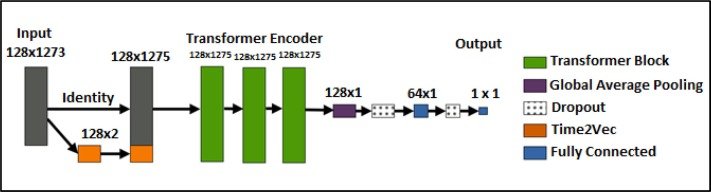

1. Input -> Time2Vec encoding + positional encoding

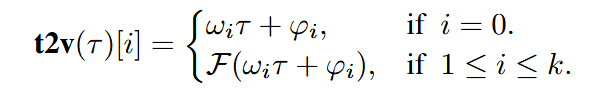

In [53]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [52]:
class Time2Vec(nn.Module):
  def __init__(self, kernel_size):
    super(Time2Vec, self).__init__()
    self.linear = nn.Linear(1,1)      #i = 0
    self.periodic = nn.Linear(1, kernel_size-1) # i = 1:k
  def forward(self, t):
    x = self.linear(t)
    y = torch.sin(self.self.periodic(t)) # F: sin
    return torch.cat([x, y], dim = -1)


Các chỉ số đầu vào:
- số lượng đặc trưng: input_dim
- số chiều của time2vec: time2vec_dim
- số chiều của vector biểu diễn cho mỗi bước thời gian: d_model


In [54]:
class Transformer(nn.Module):
  def __init__(self,seq_len, input_dim, time2vec_dim, d_model, nhead, num_layers, num_outputs):
    super(Transformer, self).__init__()
    self.time2vec = Time2Vec(seq_len,time2vec_dim)
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(d_model, 32)
    self.fc2 = nn.Linear(32,1)
  def forward(self, x):
    t2v = self.time2vec(x) # (batch_size, seq_len, time2vec_dim)
    x = torch.cat([x, t2v], dim=-1) #(batch_size, seq_len, time2vec_dim + input_dim)
    x = self.encoder(x)
    x = x.transpose(1,2) #(batch_size, total_input_dim, seq_len)
    x = self.global_avg_pool(x).squeeze(-1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.fc2(x))
    return x